In [10]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [11]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [12]:
# Load California housing data
data = fetch_california_housing()
X, y = data.data, data.target

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


In [13]:
# create pytorch dataset and dataloader

class HousingDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

# Create datasets
train_dataset = HousingDataset(X_train_tensor, y_train_tensor)
test_dataset = HousingDataset(X_test_tensor, y_test_tensor)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [ ]:
# define neural net
class HousingPriceModel(nn.Module):
    def __init__(self, input_dim):
        super(HousingPriceModel, self).__init__() # calling the __init__ of the parent class
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.network(x)

# Initialize model
input_dim = X_train.shape[1]
model = HousingPriceModel(input_dim)


In [21]:
# define optimizer
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [22]:
# train model

num_epochs = 50

for epoch in range(num_epochs):
    model.train() # activate training mode
    train_loss = 0.0
    
    for features, targets in train_loader:
        optimizer.zero_grad() #rest gradiants
        outputs = model(features) # forward pass
        loss = criterion(outputs, targets) # loss calcuation
        loss.backward() # back pass
        optimizer.step() # optimizer
        train_loss += loss.item()

    train_loss /= len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}")




Epoch 1/50, Training Loss: 0.9892
Epoch 2/50, Training Loss: 0.4264
Epoch 3/50, Training Loss: 0.3841
Epoch 4/50, Training Loss: 0.3686
Epoch 5/50, Training Loss: 0.3524
Epoch 6/50, Training Loss: 0.3407
Epoch 7/50, Training Loss: 0.3315
Epoch 8/50, Training Loss: 0.3232
Epoch 9/50, Training Loss: 0.3176
Epoch 10/50, Training Loss: 0.3115
Epoch 11/50, Training Loss: 0.3027
Epoch 12/50, Training Loss: 0.3021
Epoch 13/50, Training Loss: 0.2971
Epoch 14/50, Training Loss: 0.3017
Epoch 15/50, Training Loss: 0.2909
Epoch 16/50, Training Loss: 0.2892
Epoch 17/50, Training Loss: 0.2846
Epoch 18/50, Training Loss: 0.2883
Epoch 19/50, Training Loss: 0.2827
Epoch 20/50, Training Loss: 0.2790
Epoch 21/50, Training Loss: 0.2763
Epoch 22/50, Training Loss: 0.2770
Epoch 23/50, Training Loss: 0.2765
Epoch 24/50, Training Loss: 0.2727
Epoch 25/50, Training Loss: 0.2728
Epoch 26/50, Training Loss: 0.2715
Epoch 27/50, Training Loss: 0.2681
Epoch 28/50, Training Loss: 0.2719
Epoch 29/50, Training Loss: 0

In [50]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

model.eval()
with torch.no_grad():
    y_pred_train = model(X_train_tensor).numpy()
    y_pred_test = model(X_test_tensor).numpy()

# Compute metrics
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)

train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"Train MAE: {train_mae:.4f}, Test MAE: {test_mae:.4f}")
print(f"Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")


Train MAE: 0.3423, Test MAE: 0.3591
Train RMSE: 0.4971, Test RMSE: 0.5223


In [51]:
# Example predictions on test data
sample_data = X_test[:5]  # Take the first 5 samples from the test set
sample_tensor = torch.tensor(sample_data, dtype=torch.float32)

predicted_prices = model(sample_tensor).detach().numpy()
print("Predicted Prices:", predicted_prices.flatten())


Predicted Prices: [0.5646005 1.0921324 5.1270866 2.6462033 2.9378731]


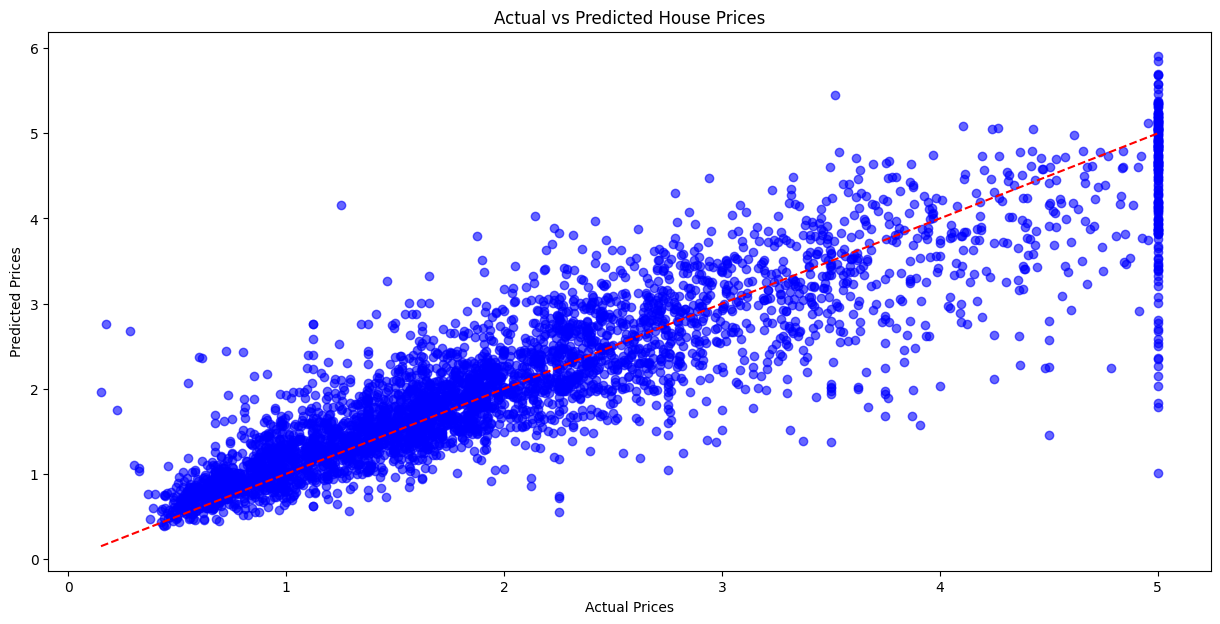

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))
plt.scatter(y_test, y_pred_test, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Perfect prediction line
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted House Prices')
plt.show()


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import numpy as np

# Define Dataset
class HousingDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Define Neural Network
class HousingPriceModel(nn.Module):
    def __init__(self, input_dim):
        super(HousingPriceModel, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.network(x)

# Data Preparation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
train_dataset = HousingDataset(X_train, y_train)
val_dataset = HousingDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Initialize Model, Loss, Optimizer
input_dim = X_train.shape[1]
model = HousingPriceModel(input_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Learning Rate Scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Training Loop with Validation and Early Stopping
num_epochs = 50
best_val_loss = float('inf')
patience = 5
epochs_no_improve = 0

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    for features, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0
    predictions = []
    actuals = []
    with torch.no_grad():
        for features, targets in val_loader:
            outputs = model(features)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

            # Track predictions and actuals for R2 score
            predictions.append(outputs.numpy())
            actuals.append(targets.numpy())

    val_loss /= len(val_loader)
    predictions = np.concatenate(predictions)
    actuals = np.concatenate(actuals)
    r2 = r2_score(actuals, predictions)

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, R²: {r2:.4f}")

    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_model.pth")  # Save best model
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break

    # Step the scheduler
    scheduler.step()

# Load Best Model for Inference
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
